<a href="https://colab.research.google.com/github/Saketkr06/Machine-learning-projects/blob/main/Multi_class_Classification_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

🛠 Practice: Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

Become one with the data (visualize, visualize, visualize...)
Preprocess the data (prepare it for a model)
Create a model (start with a baseline)
Fit the model
Evaluate the model
Adjust different parameters and improve model (try to beat your baseline)
Repeat until satisfied

## 1. Import and become one with the data

Again, we've got a subset of the Food101 dataset. In addition to the pizza and steak images, we've pulled out another eight classes.

In [1]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-05-28 16:07:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  53.1MB/s    in 10s     

2023-05-28 16:07:53 (49.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
     

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [3]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [4]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [26]:
#visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  #setup target directory
  target_folder=target_dir+target_class

  #get a random image
  random_image=random.sample(os.listdir(target_folder),1)

  #Read the image and plot it using matplotlib
  img=mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img
     


In [28]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [12]:

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
     

Image shape: (512, 512, 3)


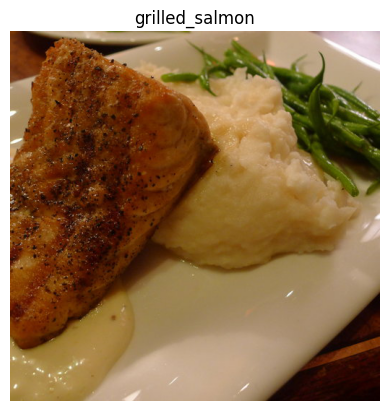

In [6]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name
     

2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


As with binary classifcation, we've creator image generators. The main change this time is that we've changed the class_mode parameter to 'categorical' because we're dealing with 10 classes of food images.

## 3. Create a model (start with a baseline)
We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:

Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
Changing the output layer to use 'softmax' activation instead of 'sigmoid' activation.
Changing the loss function to be 'categorical_crossentropy' instead of 'binary_crossentropy'.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense

model_9=Sequential([
    Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Conv2D(10,3,activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [9]:
# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [14]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 55s 214ms/step - loss: 2.1485 - accuracy: 0.2247 - val_loss: 2.0653 - val_accuracy: 0.2256
Epoch 2/5
235/235 [==============================] - 49s 210ms/step - loss: 1.9094 - accuracy: 0.3361 - val_loss: 1.8877 - val_accuracy: 0.3396
Epoch 3/5
235/235 [==============================] - 50s 211ms/step - loss: 1.5141 - accuracy: 0.4925 - val_loss: 1.9731 - val_accuracy: 0.3148
Epoch 4/5
235/235 [==============================] - 50s 211ms/step - loss: 0.8271 - accuracy: 0.7256 - val_loss: 2.5754 - val_accuracy: 0.3056
Epoch 5/5
235/235 [==============================] - 59s 250ms/step - loss: 0.2878 - accuracy: 0.9125 - val_loss: 3.8110 - val_accuracy: 0.2804


Evaluate the Test Data


In [10]:
model_9.evaluate(test_data)

79/79 [==============================] - 20s 151ms/step - loss: 2.3021 - accuracy: 0.1164


[2.3020761013031006, 0.11640000343322754]

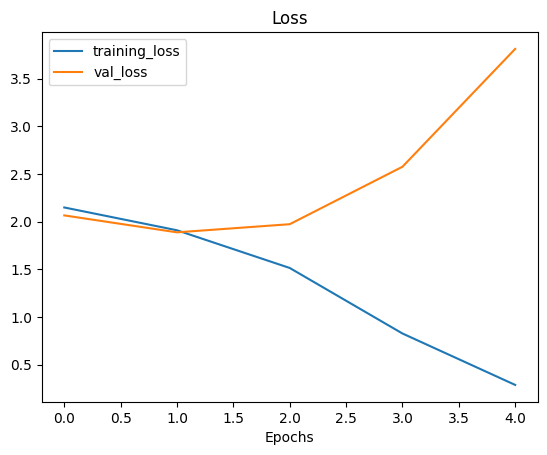

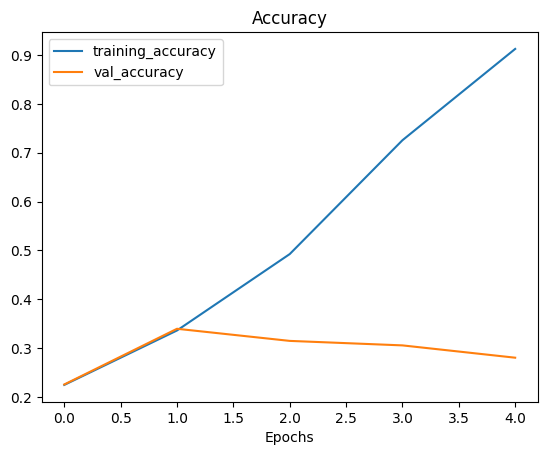

In [15]:
plot_loss_curves(history_9)

Woah, that's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is overfitting the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

6. Adjust the model parameters
Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

Get more data - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
Simplify model - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
Use data augmentation - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
Use transfer learning - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
🔑 Note: Preventing overfitting is also referred to as regularization.



In [16]:
#Try a Simplified model
model_10=Sequential([
    Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
    MaxPool2D(),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10,activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10=model_10.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 236ms/step - loss: 2.1051 - accuracy: 0.2412 - val_loss: 1.9528 - val_accuracy: 0.3036
Epoch 2/5
235/235 [==============================] - 47s 202ms/step - loss: 1.7314 - accuracy: 0.4183 - val_loss: 1.8128 - val_accuracy: 0.3548
Epoch 3/5
235/235 [==============================] - 47s 200ms/step - loss: 1.3421 - accuracy: 0.5684 - val_loss: 1.8492 - val_accuracy: 0.3552
Epoch 4/5
235/235 [==============================] - 47s 201ms/step - loss: 0.9275 - accuracy: 0.7089 - val_loss: 2.1114 - val_accuracy: 0.3488
Epoch 5/5
235/235 [==============================] - 57s 241ms/step - loss: 0.5485 - accuracy: 0.8495 - val_loss: 2.2297 - val_accuracy: 0.3448


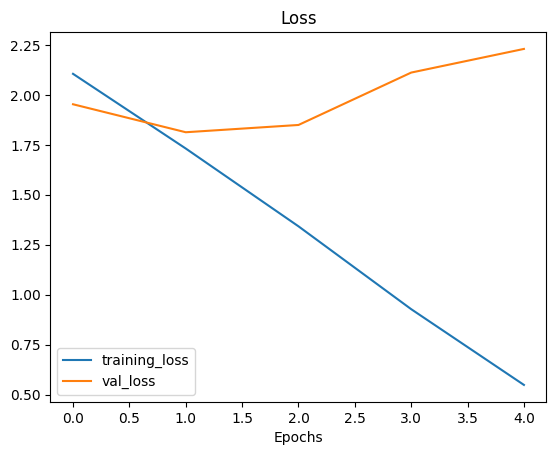

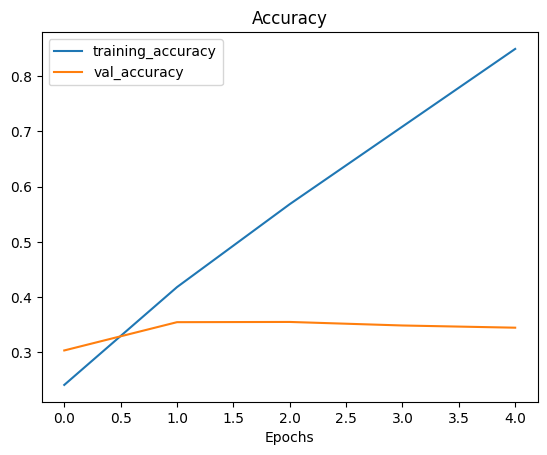

In [17]:
plot_loss_curves(history_10)

Hmm... even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about data augmentation?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new ImageDataGenerator instance, this time adding some parameters such as rotation_range and horizontal_flip to manipulate our images.

In [18]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')
     

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model as before (model_10).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called clone_model which can take an existing model and rebuild it in the same format.

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

In [19]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))
     

Epoch 1/5
235/235 [==============================] - 130s 547ms/step - loss: 2.2166 - accuracy: 0.2036 - val_loss: 1.9931 - val_accuracy: 0.2828
Epoch 2/5
235/235 [==============================] - 122s 519ms/step - loss: 2.0590 - accuracy: 0.2703 - val_loss: 1.9671 - val_accuracy: 0.3024
Epoch 3/5
235/235 [==============================] - 116s 493ms/step - loss: 2.0325 - accuracy: 0.2831 - val_loss: 1.9055 - val_accuracy: 0.3268
Epoch 4/5
235/235 [==============================] - 117s 499ms/step - loss: 2.0074 - accuracy: 0.2964 - val_loss: 1.9197 - val_accuracy: 0.3416
Epoch 5/5
235/235 [==============================] - 116s 492ms/step - loss: 1.9741 - accuracy: 0.3141 - val_loss: 1.8076 - val_accuracy: 0.3632


You can see it each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

Note: One way to improve this time taken is to use augmentation layers directly as part of the model. For example, with tf.keras.layers.RandomFlip. You can also speed up data loading with the newer tf.keras.utils.image_dataset_from_directory image loading API (we cover this later in the course).

How do our model's training curves look?

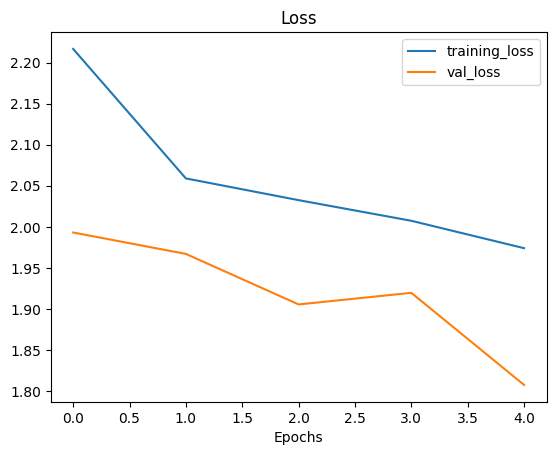

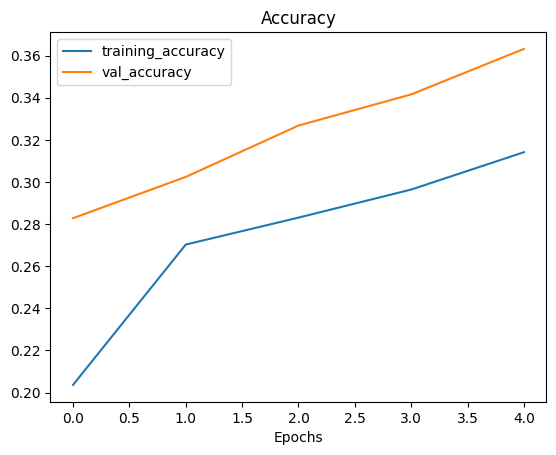

In [20]:
plot_loss_curves(history_11)

You can see it each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

Note: One way to improve this time taken is to use augmentation layers directly as part of the model. For example, with tf.keras.layers.RandomFlip. You can also speed up data loading with the newer tf.keras.utils.image_dataset_from_directory image loading API (we cover this later in the course).

How do our model's training curves look?

#Making a prediction with our trained model
What good is a model if you can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

In [21]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [22]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg



In [24]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 198ms/step


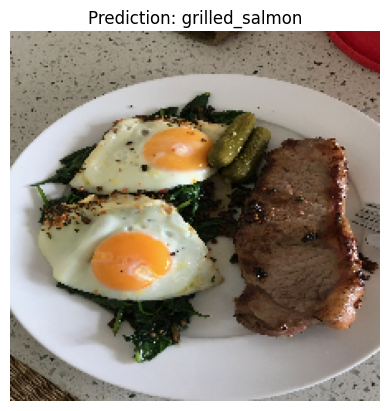

In [29]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 21ms/step


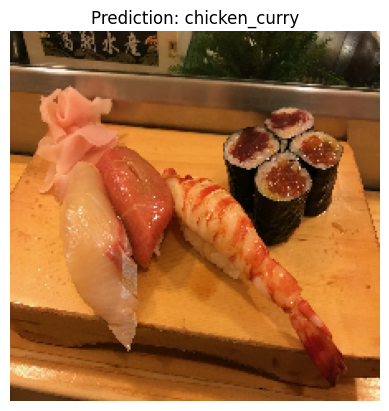

In [30]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

1/1 [==============================] - 0s 19ms/step


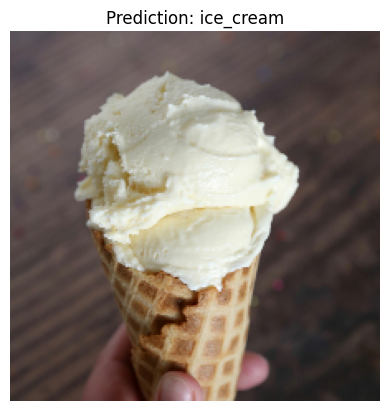

In [31]:
image='/content/homemade-vanilla-ice-cream.jpg'
pred_and_plot(model_11,image, class_names)


1/1 [==============================] - 0s 29ms/step


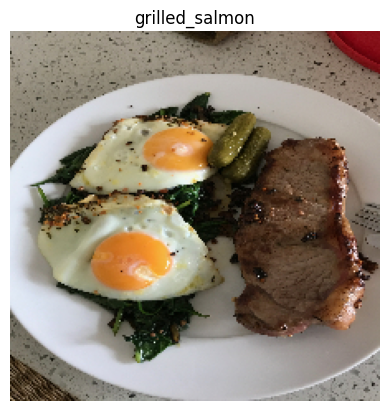

In [34]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our pred_and_plot function.

And I think I know what it is.

The pred_and_plot function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the predict function.

In [35]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

1/1 [==============================] - 0s 46ms/step


array([[0.02976744, 0.06377588, 0.05556581, 0.20228694, 0.1266509 ,
        0.1609681 , 0.01283087, 0.04143432, 0.16565304, 0.14106677]],
      dtype=float32)

In [36]:
# Find the predicted class name
class_names[pred.argmax()]

'grilled_salmon'

In [37]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than chicken_curry every time).

1/1 [==============================] - 0s 26ms/step


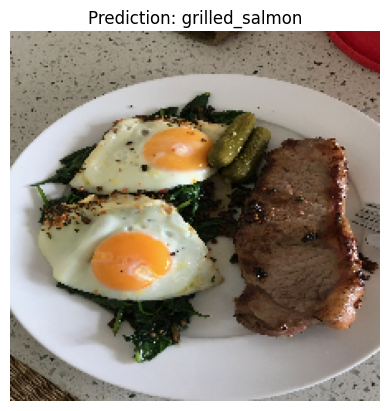

In [38]:
pred_and_plot(model_11, "03-steak.jpeg", class_names)

1/1 [==============================] - 0s 19ms/step


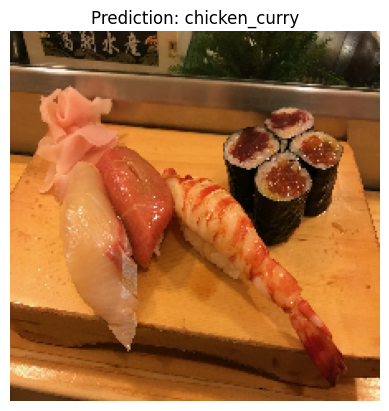

In [39]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

1/1 [==============================] - 0s 45ms/step


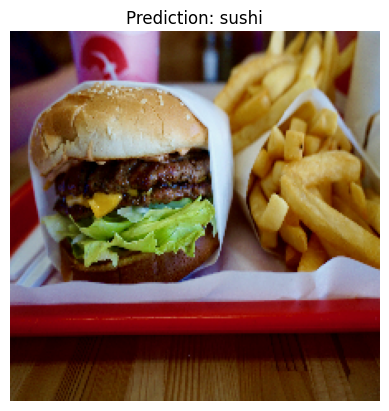

In [40]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~35% accuracy on the test dataset.

We'll see how to improve this later on (spolier: transfer learning is going to step things up a notch).

In [41]:
# Save a model
model_11.save("saved_trained_model")

In [42]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

79/79 [==============================] - 15s 183ms/step - loss: 1.8076 - accuracy: 0.3632


[1.8075507879257202, 0.36320000886917114]

In [43]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

79/79 [==============================] - 12s 149ms/step - loss: 1.8076 - accuracy: 0.3632


[1.8075501918792725, 0.36320000886917114]